### 3D-CNN

In [ ]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [ ]:
import keras
import tensorflow as tf

print("Keras Version", keras.__version__)
print("Tensorflow Version", tf.__version__)

Keras Version 2.8.0
Tensorflow Version 2.8.0


In [ ]:
from tensorflow.python.client import device_lib
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(get_available_gpus())

['/device:GPU:0']


In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10228424781933687759
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14465892352
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15741075925545537391
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [ ]:
tf.test.is_built_with_cuda()

True

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from keras.utils import np_utils
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense
from keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adadelta, SGD
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
from keras.models import Model
import cv2
import time
import os
import numpy as np
import keras
import h5py
import numpy as np
from keras import regularizers
import os
import glob
import cv2
import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import optimizers
#from keras.utils import to_categorical, plot_model
from tensorflow.keras.utils import to_categorical, plot_model
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPooling2D, Activation
from keras.models import Model, Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.models import load_model
from keras.utils import np_utils
from keras import backend as K
from keras.models import load_model
import keras
import tensorflow as tf


print("Keras Version", keras.__version__)
print("Tensorflow Version", tf.__version__)


def create_directory(directory):
    '''
    Creates a new folder in the specified directory if the folder doesn't exist.
    INPUT
        directory: Folder to be created, called as "folder/".
    OUTPUT
        New folder in the current directory.
    '''
    if not os.path.exists(directory):
        os.makedirs(directory)


base_path = os.path.abspath("/content/drive/MyDrive/Colab Notebooks/NII-Mask-TB Task/3d-resnet")
dataset_basepath = "/content/drive/MyDrive/Colab Notebooks/NII-Mask-TB Task"
dataset_path = os.path.join(dataset_basepath, "3D-image-classification-tutorial-master")

model_path = os.path.join(base_path, "models")
log_path = os.path.join(base_path, "logs")

experiment_name = "exp_siz_calcification"

create_directory(log_path)
create_directory(log_path+"/"+experiment_name)

Keras Version 2.8.0
Tensorflow Version 2.8.0


In [ ]:
from sklearn.model_selection import train_test_split

raw = np.load('{}/x_train_siz_norm_60-files.npy'.format(base_path))
labels = np.load('{}/y_train_clef_calcification.npy'.format(base_path))

print("Raw data: ", raw.shape, labels.shape)

X_train, X_test, y_train, y_test = train_test_split(raw, labels, test_size=0.2, random_state=1)
print("After splitting: ", X_train.shape, y_train.shape, X_test.shape, y_test.shape)

y = np.array([np.argmax(x) for x in y_train])
print("Count: ", np.count_nonzero(y == 1), np.count_nonzero(y == 0))

def expand_dims(val):
    val_exp = np.expand_dims(val, axis=4)
    return val_exp

X_train = expand_dims(X_train)
X_test = expand_dims(X_test)
print("After expanding: ", X_train.shape, X_test.shape)

Raw data:  (60, 128, 128, 64) (60, 2)
After splitting:  (48, 128, 128, 64) (48, 2) (12, 128, 128, 64) (12, 2)
Count:  26 22
After expanding:  (48, 128, 128, 64, 1) (12, 128, 128, 64, 1)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 63, 63, 31, 64)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 31, 64)   256       
 ormalization)                                                   
                                                                 
 conv3d_2 (Conv3D)           (None, 61, 61, 29, 64)    110656    
                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


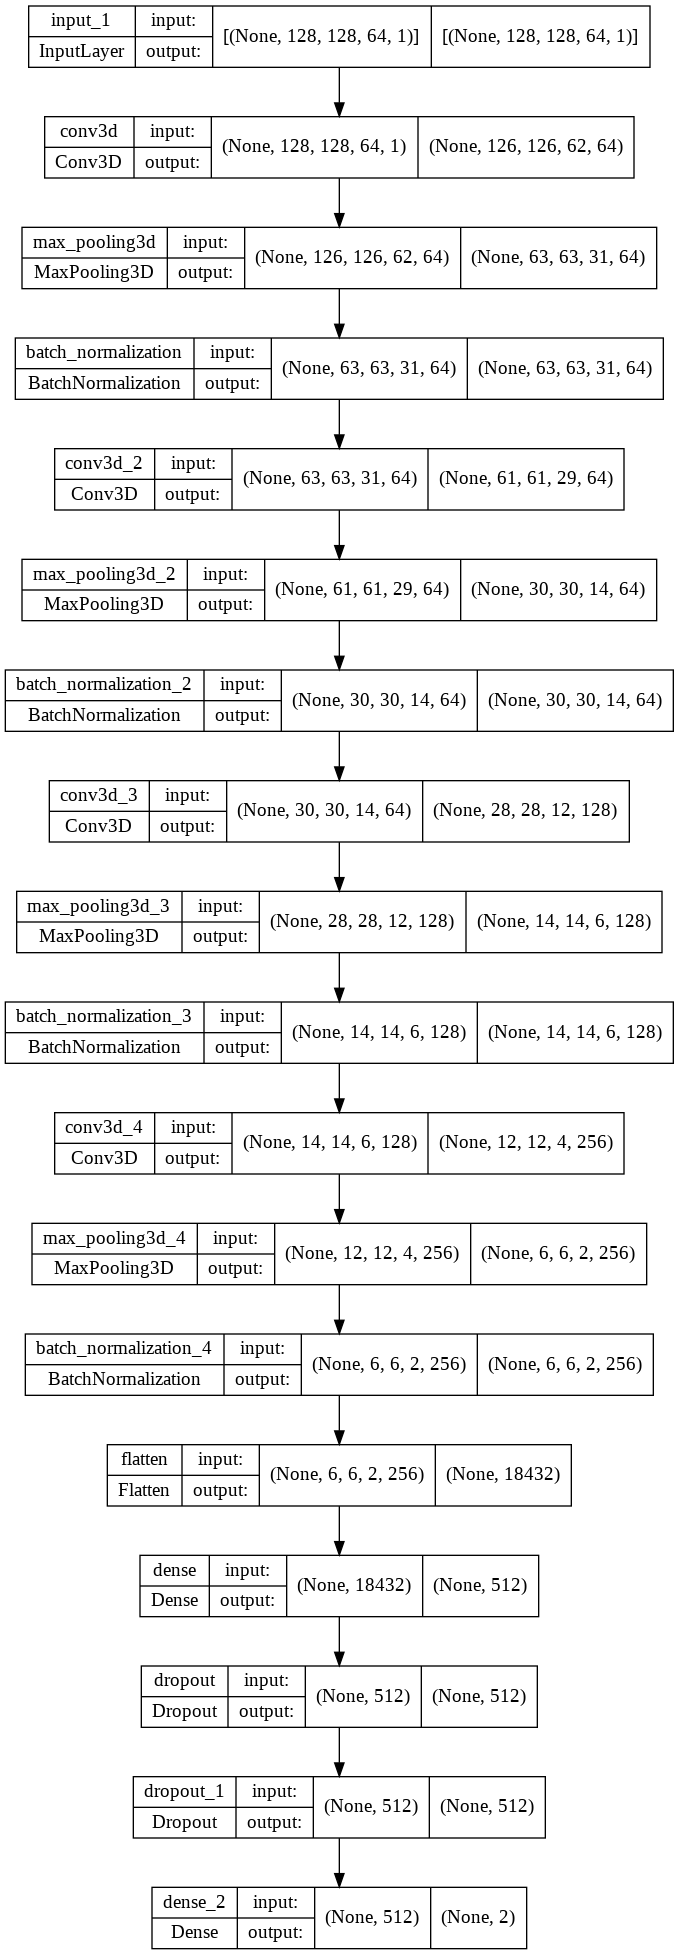

In [ ]:
weights_path = "{}/{}.h5".format(log_path+"/"+experiment_name, "best_model")
checkpointer = ModelCheckpoint(filepath=weights_path, verbose=1, monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-8, mode='auto')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, verbose=1, patience=8, mode='auto', restore_best_weights=True)
csv_logger = CSVLogger('{}/training.csv'.format(log_path+"/"+experiment_name))

from sklearn.utils import class_weight

def network_3d():

    input_layer = Input((128, 128, 64, 1))

    conv_layer1 = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu')(input_layer)
    pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer1)

    pooling_layer1 = BatchNormalization()(pooling_layer1)
    conv_layer2 = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu')(pooling_layer1)
    pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)
    pooling_layer2 = BatchNormalization()(pooling_layer2)
    conv_layer3 = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu')(pooling_layer1)
    pooling_layer3 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer3)
    pooling_layer3 = BatchNormalization()(pooling_layer3)
    conv_layer4 = Conv3D(filters=128, kernel_size=(3, 3, 3), activation='relu')(pooling_layer3)
    pooling_layer4 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer4)
    pooling_layer4 = BatchNormalization()(pooling_layer4)
    conv_layer5 = Conv3D(filters=256, kernel_size=(3, 3, 3), activation='relu')(pooling_layer4)
    pooling_layer5 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer5)

    pooling_layer9 = BatchNormalization()(pooling_layer5)
    flatten_layer = Flatten()(pooling_layer9)

    dense_layer3 = Dense(units=512, activation='relu')(flatten_layer)
    dense_layer3 = Dropout(0.4)(dense_layer3)

    dense_layer4 = Dense(units=256, activation='relu')(dense_layer3)
    dense_layer4 = Dropout(0.4)(dense_layer3)

    output_layer = Dense(units=2, activation='softmax')(dense_layer4)

    model = Model(inputs=input_layer, outputs=output_layer)

    model.compile(loss='mae', optimizer=SGD(lr=1e-06, momentum=0.99, decay=0.0, nesterov=False), metrics=['acc'])

    return model

model = None
model = network_3d()
model.summary()
tf.keras.utils.plot_model(model, to_file='/tbt_classification.png', show_shapes=True, show_layer_names=True)

In [ ]:
from keras.utils import np_utils

In [ ]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
print(kfold)

data = X_train
labels = np.array([np.argmax(x) for x in y_train])
print(data.shape, labels.shape)

cross_val_scores = []

start_time = time.time()

for i, (train, test) in enumerate(kfold.split(data, labels)):

    print("Fold - {}".format(i), data[train].shape, labels[train].shape, data[test].shape, labels[test].shape)

    K.clear_session()
    model = None

    start_time = time.time()

    model = network_3d()

    y_train_cv = keras.utils.np_utils.to_categorical(labels[train], 2)
    y_val_cv = keras.utils.np_utils.to_categorical(labels[test], 2)

    cb = None
    cw = None

    h=model.fit(x=data[train],
                y=y_train_cv,
                validation_data=(data[test], y_val_cv),
                batch_size=2,
                epochs=100,
                verbose=1,
                class_weight = cw,
                callbacks=cb,
                shuffle=False,
                )

    y_pred_cv = []

    for img in data[test]:
        img = np.expand_dims(img, axis=0)
        y = model.predict(img)
        y_pred_cv.append(y[:][0])

    y_pred_cv = np.array(y_pred_cv)

    y_val_cv_flat = np.argmax(y_val_cv, axis=1)
    y_pred_cv_flat = np.array([np.argmax(pred) for pred in y_pred_cv])

    acc = accuracy_score(y_val_cv_flat, y_pred_cv_flat) * 100
    print("Fold {} accuracy :".format(i), acc)

    cross_val_scores.append(acc)


end_time = time.time()
print("--- Time taken to train : %s hours ---" % ((end_time - start_time)//3600))

StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
(48, 128, 128, 64, 1) (48,)
Fold - 0 (43, 128, 128, 64, 1) (43,) (5, 128, 128, 64, 1) (5,)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
22/22 [==============================] - 22s 457ms/step - loss: 0.4715 - acc: 0.5581 - val_loss: 0.4794 - val_acc: 0.6000
Epoch 2/100
22/22 [==============================] - 9s 396ms/step - loss: 0.5613 - acc: 0.4419 - val_loss: 0.4596 - val_acc: 0.6000
Epoch 3/100
22/22 [==============================] - 9s 398ms/step - loss: 0.4270 - acc: 0.5814 - val_loss: 0.4438 - val_acc: 0.6000
Epoch 4/100
22/22 [==============================] - 9s 400ms/step - loss: 0.3918 - acc: 0.6279 - val_loss: 0.4320 - val_acc: 0.6000
Epoch 5/100
22/22 [==============================] - 9s 401ms/step - loss: 0.3680 - acc: 0.6744 - val_loss: 0.4236 - val_acc: 0.6000
Epoch 6/100
22/22 [==============================] - 9s 401ms/step - loss: 0.3270 - acc: 0.6512 - val_loss: 0.4178 - val_acc: 0.6000
Epoch 7/100
22/22 [==============================] - 9s 408ms/step - loss: 0.3813 - acc: 0.6047 - val_loss: 0.4135 - val_acc: 0.6000
Epoch 8/100
22/22 [==============================] - 9s 402ms/step -

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
22/22 [==============================] - 10s 410ms/step - loss: 0.4912 - acc: 0.5116 - val_loss: 0.5036 - val_acc: 0.4000
Epoch 2/100
22/22 [==============================] - 9s 401ms/step - loss: 0.5798 - acc: 0.4186 - val_loss: 0.5041 - val_acc: 0.4000
Epoch 3/100
22/22 [==============================] - 9s 399ms/step - loss: 0.4567 - acc: 0.5349 - val_loss: 0.5032 - val_acc: 0.4000
Epoch 4/100
22/22 [==============================] - 9s 401ms/step - loss: 0.4638 - acc: 0.5116 - val_loss: 0.5008 - val_acc: 0.4000
Epoch 5/100
22/22 [==============================] - 9s 399ms/step - loss: 0.3723 - acc: 0.6744 - val_loss: 0.4975 - val_acc: 0.6000
Epoch 6/100
22/22 [==============================] - 9s 400ms/step - loss: 0.4553 - acc: 0.5116 - val_loss: 0.4932 - val_acc: 0.6000
Epoch 7/100
22/22 [==============================] - 9s 400ms/step - loss: 0.3163 - acc: 0.6977 - val_loss: 0.4883 - val_acc: 0.6000
Epoch 8/100
22/22 [==============================] - 9s 402ms/step -

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
22/22 [==============================] - 10s 409ms/step - loss: 0.5750 - acc: 0.4419 - val_loss: 0.4902 - val_acc: 0.6000
Epoch 2/100
22/22 [==============================] - 9s 400ms/step - loss: 0.4820 - acc: 0.5349 - val_loss: 0.4817 - val_acc: 0.6000
Epoch 3/100
22/22 [==============================] - 9s 400ms/step - loss: 0.5878 - acc: 0.4186 - val_loss: 0.4746 - val_acc: 0.6000
Epoch 4/100
22/22 [==============================] - 9s 400ms/step - loss: 0.4846 - acc: 0.5349 - val_loss: 0.4694 - val_acc: 0.6000
Epoch 5/100
22/22 [==============================] - 9s 399ms/step - loss: 0.4710 - acc: 0.4884 - val_loss: 0.4648 - val_acc: 0.6000
Epoch 6/100
22/22 [==============================] - 9s 400ms/step - loss: 0.4037 - acc: 0.6279 - val_loss: 0.4612 - val_acc: 0.6000
Epoch 7/100
22/22 [==============================] - 9s 400ms/step - loss: 0.4056 - acc: 0.5349 - val_loss: 0.4590 - val_acc: 0.6000
Epoch 8/100
22/22 [==============================] - 9s 401ms/step -

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
22/22 [==============================] - 10s 408ms/step - loss: 0.5449 - acc: 0.3953 - val_loss: 0.4989 - val_acc: 0.6000
Epoch 2/100
22/22 [==============================] - 9s 401ms/step - loss: 0.5318 - acc: 0.4651 - val_loss: 0.4968 - val_acc: 0.6000
Epoch 3/100
22/22 [==============================] - 9s 400ms/step - loss: 0.4959 - acc: 0.5116 - val_loss: 0.4944 - val_acc: 0.6000
Epoch 4/100
22/22 [==============================] - 9s 401ms/step - loss: 0.5316 - acc: 0.4651 - val_loss: 0.4933 - val_acc: 0.6000
Epoch 5/100
22/22 [==============================] - 9s 400ms/step - loss: 0.4573 - acc: 0.5814 - val_loss: 0.4933 - val_acc: 0.6000
Epoch 6/100
22/22 [==============================] - 9s 401ms/step - loss: 0.3941 - acc: 0.5581 - val_loss: 0.4934 - val_acc: 0.6000
Epoch 7/100
22/22 [==============================] - 9s 398ms/step - loss: 0.4749 - acc: 0.5349 - val_loss: 0.4941 - val_acc: 0.6000
Epoch 8/100
22/22 [==============================] - 9s 401ms/step -

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
22/22 [==============================] - 10s 408ms/step - loss: 0.4728 - acc: 0.5581 - val_loss: 0.4866 - val_acc: 0.6000
Epoch 2/100
22/22 [==============================] - 9s 401ms/step - loss: 0.4405 - acc: 0.6047 - val_loss: 0.4749 - val_acc: 0.6000
Epoch 3/100
22/22 [==============================] - 9s 401ms/step - loss: 0.5197 - acc: 0.4884 - val_loss: 0.4652 - val_acc: 0.6000
Epoch 4/100
22/22 [==============================] - 9s 401ms/step - loss: 0.3981 - acc: 0.6279 - val_loss: 0.4575 - val_acc: 0.6000
Epoch 5/100
22/22 [==============================] - 9s 400ms/step - loss: 0.4034 - acc: 0.5814 - val_loss: 0.4515 - val_acc: 0.6000
Epoch 6/100
22/22 [==============================] - 9s 400ms/step - loss: 0.3858 - acc: 0.6047 - val_loss: 0.4469 - val_acc: 0.6000
Epoch 7/100
22/22 [==============================] - 9s 400ms/step - loss: 0.3358 - acc: 0.6744 - val_loss: 0.4431 - val_acc: 0.6000
Epoch 8/100
22/22 [==============================] - 9s 399ms/step -

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
22/22 [==============================] - 10s 409ms/step - loss: 0.5145 - acc: 0.4884 - val_loss: 0.5156 - val_acc: 0.4000
Epoch 2/100
22/22 [==============================] - 9s 401ms/step - loss: 0.4604 - acc: 0.5581 - val_loss: 0.5305 - val_acc: 0.4000
Epoch 3/100
22/22 [==============================] - 9s 401ms/step - loss: 0.4511 - acc: 0.5581 - val_loss: 0.5433 - val_acc: 0.4000
Epoch 4/100
22/22 [==============================] - 9s 402ms/step - loss: 0.4734 - acc: 0.6047 - val_loss: 0.5538 - val_acc: 0.4000
Epoch 5/100
22/22 [==============================] - 9s 399ms/step - loss: 0.4541 - acc: 0.5581 - val_loss: 0.5620 - val_acc: 0.4000
Epoch 6/100
22/22 [==============================] - 9s 415ms/step - loss: 0.3664 - acc: 0.6512 - val_loss: 0.5685 - val_acc: 0.4000
Epoch 7/100
22/22 [==============================] - 9s 399ms/step - loss: 0.3514 - acc: 0.6744 - val_loss: 0.5737 - val_acc: 0.4000
Epoch 8/100
22/22 [==============================] - 9s 400ms/step -

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
22/22 [==============================] - 10s 422ms/step - loss: 0.4399 - acc: 0.5814 - val_loss: 0.5028 - val_acc: 0.4000
Epoch 2/100
22/22 [==============================] - 9s 398ms/step - loss: 0.4634 - acc: 0.5349 - val_loss: 0.5066 - val_acc: 0.4000
Epoch 3/100
22/22 [==============================] - 9s 411ms/step - loss: 0.5391 - acc: 0.4651 - val_loss: 0.5105 - val_acc: 0.4000
Epoch 4/100
22/22 [==============================] - 9s 411ms/step - loss: 0.4265 - acc: 0.5814 - val_loss: 0.5138 - val_acc: 0.4000
Epoch 5/100
22/22 [==============================] - 9s 398ms/step - loss: 0.3902 - acc: 0.6512 - val_loss: 0.5169 - val_acc: 0.4000
Epoch 6/100
22/22 [==============================] - 9s 400ms/step - loss: 0.4112 - acc: 0.6512 - val_loss: 0.5202 - val_acc: 0.4000
Epoch 7/100
22/22 [==============================] - 9s 398ms/step - loss: 0.3037 - acc: 0.6977 - val_loss: 0.5232 - val_acc: 0.4000
Epoch 8/100
22/22 [==============================] - 9s 398ms/step -

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
22/22 [==============================] - 10s 409ms/step - loss: 0.4649 - acc: 0.5349 - val_loss: 0.4868 - val_acc: 0.6000
Epoch 2/100
22/22 [==============================] - 9s 400ms/step - loss: 0.4463 - acc: 0.6047 - val_loss: 0.4759 - val_acc: 0.6000
Epoch 3/100
22/22 [==============================] - 9s 400ms/step - loss: 0.4575 - acc: 0.5581 - val_loss: 0.4673 - val_acc: 0.6000
Epoch 4/100
22/22 [==============================] - 9s 401ms/step - loss: 0.4426 - acc: 0.5814 - val_loss: 0.4609 - val_acc: 0.6000
Epoch 5/100
22/22 [==============================] - 9s 399ms/step - loss: 0.4681 - acc: 0.5349 - val_loss: 0.4560 - val_acc: 0.6000
Epoch 6/100
22/22 [==============================] - 9s 401ms/step - loss: 0.4105 - acc: 0.6047 - val_loss: 0.4526 - val_acc: 0.6000
Epoch 7/100
22/22 [==============================] - 9s 413ms/step - loss: 0.3204 - acc: 0.6977 - val_loss: 0.4514 - val_acc: 0.6000
Epoch 8/100
22/22 [==============================] - 9s 401ms/step -

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
22/22 [==============================] - 10s 414ms/step - loss: 0.4795 - acc: 0.5455 - val_loss: 0.5003 - val_acc: 0.5000
Epoch 2/100
22/22 [==============================] - 9s 406ms/step - loss: 0.4943 - acc: 0.4773 - val_loss: 0.5003 - val_acc: 0.5000
Epoch 3/100
22/22 [==============================] - 9s 404ms/step - loss: 0.4682 - acc: 0.5455 - val_loss: 0.5004 - val_acc: 0.5000
Epoch 4/100
22/22 [==============================] - 9s 406ms/step - loss: 0.4366 - acc: 0.5909 - val_loss: 0.5005 - val_acc: 0.5000
Epoch 5/100
22/22 [==============================] - 9s 405ms/step - loss: 0.3373 - acc: 0.7045 - val_loss: 0.5008 - val_acc: 0.5000
Epoch 6/100
22/22 [==============================] - 9s 403ms/step - loss: 0.2994 - acc: 0.7500 - val_loss: 0.5011 - val_acc: 0.5000
Epoch 7/100
22/22 [==============================] - 9s 404ms/step - loss: 0.3355 - acc: 0.6818 - val_loss: 0.5016 - val_acc: 0.5000
Epoch 8/100
22/22 [==============================] - 9s 405ms/step -

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
22/22 [==============================] - 10s 412ms/step - loss: 0.4820 - acc: 0.5000 - val_loss: 0.4999 - val_acc: 0.5000
Epoch 2/100
22/22 [==============================] - 9s 404ms/step - loss: 0.4443 - acc: 0.5909 - val_loss: 0.4997 - val_acc: 0.5000
Epoch 3/100
22/22 [==============================] - 9s 404ms/step - loss: 0.4339 - acc: 0.5682 - val_loss: 0.4999 - val_acc: 0.5000
Epoch 4/100
22/22 [==============================] - 9s 403ms/step - loss: 0.3905 - acc: 0.6364 - val_loss: 0.4996 - val_acc: 0.5000
Epoch 5/100
22/22 [==============================] - 9s 404ms/step - loss: 0.3338 - acc: 0.6591 - val_loss: 0.4994 - val_acc: 0.5000
Epoch 6/100
22/22 [==============================] - 9s 404ms/step - loss: 0.3507 - acc: 0.6591 - val_loss: 0.4990 - val_acc: 0.5000
Epoch 7/100
22/22 [==============================] - 9s 404ms/step - loss: 0.3726 - acc: 0.6818 - val_loss: 0.4989 - val_acc: 0.5000
Epoch 8/100
22/22 [==============================] - 9s 404ms/step -

#### Mean and standard deviation

In [ ]:
print("%.2f%% (+/- %.2f%%)" % (np.mean(cross_val_scores), np.std(cross_val_scores)))

55.00% (+/- 25.00%)


In [ ]:
print(h.history.keys())
print(h.history['val_loss'])

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])
[0.4999277591705322, 0.49966198205947876, 0.4999476373195648, 0.499646931886673, 0.499433696269989, 0.4989624321460724, 0.4989268183708191, 0.4990898072719574, 0.49855685234069824, 0.4974120855331421, 0.49662718176841736, 0.49534034729003906, 0.4942165017127991, 0.49356016516685486, 0.49122992157936096, 0.49026796221733093, 0.4899458885192871, 0.49151843786239624, 0.4954996705055237, 0.4977559745311737, 0.5027148127555847, 0.5015344023704529, 0.4945009648799896, 0.49567103385925293, 0.4932624101638794, 0.4917961061000824, 0.4752740263938904, 0.45852455496788025, 0.4619207978248596, 0.48163846135139465, 0.4842751622200012, 0.496237576007843, 0.4918803870677948, 0.4871976673603058, 0.48550719022750854, 0.4929032027721405, 0.5016011595726013, 0.5222775936126709, 0.5269811153411865, 0.5368167161941528, 0.5455628633499146, 0.5545133352279663, 0.544394314289093, 0.536199688911438, 0.5278774499893188, 0.5323988795280457, 0.5330386161804199, 0.

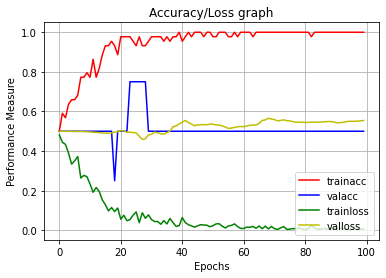

Done training and logging!


In [ ]:
def plot_loss_accu_all(his):

    loss = his.history['loss']
    val_loss = his.history['val_loss']
    acc = his.history['acc']
    val_acc = his.history['val_acc']
    epochs = range(len(loss))

    plt.plot(epochs, acc, 'r')
    plt.plot(epochs, val_acc, 'b')
    plt.plot(epochs, loss, 'g')
    plt.plot(epochs, val_loss, 'y')
    plt.title('Accuracy/Loss graph')

    plt.ylabel('Performance Measure')
    plt.xlabel('Epochs')

    plt.legend(['trainacc', 'valacc', 'trainloss', 'valloss'], loc='lower right', fontsize=10)
    plt.grid(True)
    plt.savefig('{}/{}.png'.format(log_path+"/"+experiment_name, "trainval_acc_loss"), dpi=500)
    plt.show()


def plot_loss_accu(his):
    loss = his.history['loss']
    val_loss = his.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'g')
    plt.plot(epochs, val_loss, 'y')
    plt.ylabel('Loss %')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.grid(True)
    plt.show()

    loss = his.history['acc']
    val_loss = his.history['val_acc']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    plt.ylabel('Accuracy %')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.grid(True)
    plt.show()

plot_loss_accu_all(h)
print("Done training and logging!")

In [ ]:
model.save("{}/{}.h5".format(log_path+"/"+experiment_name, experiment_name))

In [ ]:
model = None
model = load_model("{}/exp_siz_calcification/exp_siz_calcification.h5".format(log_path))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 63, 63, 31, 64)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 31, 64)   256       
 ormalization)                                                   
                                                                 
 conv3d_2 (Conv3D)           (None, 61, 61, 29, 64)    110656    
                                                             

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

1/1 [==============================] - 3s 3s/step - loss: 0.3344 - acc: 0.7500
Test loss: 0.334440141916275
Test accuracy: 0.75


In [ ]:
y_pred = []

for img in X_test:
    img = np.expand_dims(img, axis=0)
    y = model.predict(img)
    y_pred.append(y[:][0])

y_pred = np.array(y_pred)
print(y_pred.shape)

y_test_flat = np.argmax(y_test, axis=1)
print("After flattening ground truth: ", y_test_flat.shape)

y_pred_flat = np.array([np.argmax(pred) for pred in y_pred])
print("Binarize probability values: ", y_pred_flat.shape)

acc = accuracy_score(y_test_flat, y_pred_flat) * 100
print("Accuracy :", acc)

(12, 2)
After flattening ground truth:  (12,)
Binarize probability values:  (12,)
Accuracy : 75.0


In [ ]:
print(y_pred)
print(y_test)
print(y_test_flat)
print(y_pred_flat)

[[0.14198878 0.85801125]
 [0.6559245  0.34407544]
 [0.7469147  0.25308535]
 [0.83460516 0.16539486]
 [0.65788114 0.3421189 ]
 [0.44094294 0.55905706]
 [0.27640876 0.72359127]
 [0.71195483 0.28804517]
 [0.10040498 0.8995951 ]
 [0.00559268 0.9944073 ]
 [0.17317893 0.826821  ]
 [0.02634692 0.973653  ]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
[0 0 0 0 1 1 1 1 1 1 1 1]
[1 0 0 0 0 1 1 0 1 1 1 1]


In [ ]:
print(np_utils.to_categorical(y_pred))

[[[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]

 [[1.]
  [1.]]]


In [ ]:
len(X_test)

12

In [ ]:
num_classes = 2
target_names = ['0', '1']
target_names = np_utils.to_categorical(target_names, num_classes)
target_names.shape

(2, 2)

In [ ]:
target_names

array([[1., 0.],
       [0., 1.]], dtype=float32)

In [ ]:
y_test_flat

array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

confusion_mtx = confusion_matrix(y_test_flat, y_pred_flat)
print(confusion_mtx)
print(classification_report(y_test_flat, y_pred_flat, labels=[0.,1.]))

[[3 1]
 [2 6]]
              precision    recall  f1-score   support

         0.0       0.60      0.75      0.67         4
         1.0       0.86      0.75      0.80         8

    accuracy                           0.75        12
   macro avg       0.73      0.75      0.73        12
weighted avg       0.77      0.75      0.76        12



In [ ]:
from sklearn.metrics import roc_auc_score
print('Area under ROC curve : ', roc_auc_score(y_test, y_pred) *100 )

Area under ROC curve :  78.125


Area under the ROC curve for positive class: 0.78125


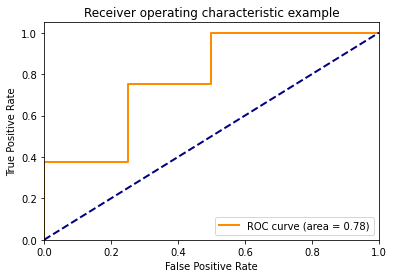

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


cls = 1
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print("Area under the ROC curve for positive class:", roc_auc[1])


plt.figure()
lw = 2
plt.plot(fpr[cls], tpr[cls], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[cls])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.savefig('{}/{}.png'.format(log_path+"/"+experiment_name, "roc"), dpi=500)
plt.show()

In [ ]:
import pickle

def save_obj(obj, name):
    with open('{}'.format(log_path+"/") + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('{}'.format(log_path+"/") + name + '.pkl', 'rb') as f:
        return pickle.load(f)

ascore = {}
ascore["fpr"] = fpr[cls]
ascore["tpr"] = tpr[cls]
ascore["roc_auc"] = roc_auc[cls]
save_obj(ascore, experiment_name)

type(fpr[cls]), roc_auc[cls]

(numpy.ndarray, 0.78125)

### Creating inference submission files for ImageCLEF

In [ ]:
model = None
model = load_model("{}/exp_siz_calcification/exp_siz_calcification.h5".format(log_path))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 63, 63, 31, 64)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 31, 64)   256       
 ormalization)                                                   
                                                                 
 conv3d_2 (Conv3D)           (None, 61, 61, 29, 64)    110656    
                                                             

In [ ]:
!pip install tqdm

In [ ]:
!pip install SimpleITK

     |████████████████████████████████| 48.4 MB 1.4 MB/s 


In [ ]:
w, h = 128, 128
def rs_img(img):
    '''W and H is 128 now
    '''
    img = np.transpose(img)
    flatten = [cv2.resize(img[:,:,i], (w, h), interpolation=cv2.INTER_CUBIC) for i in range(img.shape[-1])]
    img = np.array(np.dstack(flatten))
    return img


def change_depth_sss(img):
    factor = 16
    img_start = img[:,:,:factor]

    mid = int(img.shape[-1]/2)
    img_middle = img[:,:,mid-factor:mid+factor]

    img_end = img[:,:,-factor:]
    img = np.concatenate((img_start, img_middle, img_end), axis=2)
    return img


def change_depth_ess(img):
    target_depth = 64
    scan_depth = int(img.shape[-1])

    if scan_depth < 64:
        number = 64 - scan_depth
        extend = [img[:,:,-1] for _ in range(number)]
        extend = np.array(np.dstack(extend))
        img = np.concatenate((img, extend), axis=2)

    else:
        factor = int(np.floor(scan_depth / target_depth))

        flatten = []
        idx = 0

        for i in range(0, scan_depth, factor):
          #print(idx)

            if idx>=scan_depth:
                break
            else:
                flatten.append(img[:,:,i])

        img = np.array(np.dstack(flatten))

    img = img[:,:,:target_depth]

    assert img.shape[-1] == target_depth , "Error"
    return img


def change_depth_siz(img):
    desired_depth = 64
    current_depth = img.shape[-1]
    depth = current_depth / desired_depth
    depth_factor = 1 / depth
    img_new = zoom(img, (1, 1, depth_factor), mode='nearest')
    return img_new

def normalize(image):
    global MIN_BOUND
    global MAX_BOUND

    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image


def zero_center(image):
    image = image - PIXEL_MEAN
    return image


def plot_seq(data, name):
    a, b = 3, 20
    data = np.reshape(data, (a, b, 128, 128))
    test_data = data
    r, c = test_data.shape[0], test_data.shape[1]

    cmaps = [['viridis', 'binary'], ['plasma', 'coolwarm'], ['Greens', 'copper']]

    heights = [a[0].shape[0] for a in test_data]
    widths = [a.shape[1] for a in test_data[0]]

    fig_width = 10.  # inches
    fig_height = fig_width * sum(heights) / sum(widths)

    f, axarr = plt.subplots(r,c, figsize=(fig_width, fig_height),
          gridspec_kw={'height_ratios':heights})

    for i in range(r):
        for j in range(c):
            axarr[i, j].imshow(test_data[i][j], cmap='gray')
            axarr[i, j].axis('off')

    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.savefig('{}/{}.png'.format(log_path, name), dpi=1000)
    plt.show()


def resize_depth_wise(img3d):
    p = img3d
    p_2d = []

    depth = 2

    n = 0
    c = 0

    for c in range(70):
        img = img3d[:,:,n+depth]
        p_2d.append(img)
        n = n+depth
        c = c+1

    p_3d_d64 = np.array(np.dstack(p_2d))
    return p_3d_d64

In [ ]:
from tqdm import tqdm
import SimpleITK as sitk
INPUT_FOLDER = 'Test Data/'
test_data_raw = os.path.join(dataset_path, INPUT_FOLDER)

patients_test = sorted(os.listdir(test_data_raw))
print(len(patients_test))
print(patients_test[:2])

pts_test = []

for ps in tqdm(patients_test[:]):

    print("Image Name", ps)
    img = sitk.ReadImage(test_data_raw + ps)
    img = sitk.GetArrayFromImage(img)

    img = rs_img(img)

    img = change_depth_sss(img)

    pts_test.append(img)
    img=None

test_data = np.array(pts_test)
test_data.shape

16
['TST_00.nii.gz', 'TST_01.nii.gz']


  0%|          | 0/16 [00:00<?, ?it/s]

Image Name TST_00.nii.gz


  6%|▋         | 1/16 [00:01<00:16,  1.12s/it]

Image Name TST_01.nii.gz


 12%|█▎        | 2/16 [00:07<00:58,  4.17s/it]

Image Name TST_02.nii.gz


 19%|█▉        | 3/16 [00:16<01:20,  6.20s/it]

Image Name TST_03.nii.gz


 25%|██▌       | 4/16 [00:24<01:25,  7.10s/it]

Image Name TST_04.nii.gz


 31%|███▏      | 5/16 [00:33<01:24,  7.67s/it]

Image Name TST_05.nii.gz


 38%|███▊      | 6/16 [00:40<01:16,  7.62s/it]

Image Name TST_06.nii.gz


 44%|████▍     | 7/16 [00:47<01:04,  7.20s/it]

Image Name TST_07.nii.gz


 50%|█████     | 8/16 [00:53<00:55,  6.90s/it]

Image Name TST_08.nii.gz


 56%|█████▋    | 9/16 [00:54<00:36,  5.21s/it]

Image Name TST_09.nii.gz


 62%|██████▎   | 10/16 [00:59<00:30,  5.15s/it]

Image Name TST_10.nii.gz


 69%|██████▉   | 11/16 [01:04<00:24,  5.00s/it]

Image Name TST_11.nii.gz


 75%|███████▌  | 12/16 [01:09<00:20,  5.15s/it]

Image Name TST_12.nii.gz


 81%|████████▏ | 13/16 [01:11<00:11,  3.99s/it]

Image Name TST_13.nii.gz


 88%|████████▊ | 14/16 [01:15<00:07,  3.99s/it]

Image Name TST_14.nii.gz


 94%|█████████▍| 15/16 [01:21<00:04,  4.60s/it]

Image Name TST_15.nii.gz


100%|██████████| 16/16 [01:25<00:00,  5.37s/it]


(16, 128, 128, 64)

In [ ]:
MIN_BOUND = np.min(test_data)
MAX_BOUND = np.max(test_data)
PIXEL_MEAN = np.mean(test_data)

print("Min", MIN_BOUND)
print("Min", MAX_BOUND)
print("Mean", PIXEL_MEAN)

Min -2566
Min 4676
Mean -716.157154738903


In [ ]:
x_test = normalize(test_data)
np.max(x_test), np.min(x_test)

(1.0, 0.0)

In [ ]:
MIN_BOUND = np.min(x_test)
MAX_BOUND = np.max(x_test)
PIXEL_MEAN = np.mean(x_test)

print("Min", MIN_BOUND)
print("Max", MAX_BOUND)
print("Mean", PIXEL_MEAN)

Min 0.0
Max 1.0
Mean 0.2554325939327664


In [ ]:
def expand_dims(val):
    val_exp = np.expand_dims(val, axis=4)
    return val_exp

In [ ]:
len(x_test)

16

In [ ]:
y_pred = []

for img in x_test:
    img = np.expand_dims(img, axis=0)
    y = model.predict(img)
    y_pred.append(y[:][0])

y_pred = np.array(y_pred)
print(y_pred.shape)

(16, 2)


In [ ]:
y_pred

array([[3.5873146e-03, 9.9641269e-01],
       [1.6528033e-01, 8.3471966e-01],
       [1.1590580e-02, 9.8840940e-01],
       [8.9678133e-04, 9.9910331e-01],
       [7.0008479e-02, 9.2999148e-01],
       [1.8417996e-01, 8.1582010e-01],
       [9.9634737e-02, 9.0036529e-01],
       [3.9069018e-01, 6.0930979e-01],
       [3.9454160e-04, 9.9960548e-01],
       [2.7374342e-02, 9.7262561e-01],
       [3.4893714e-02, 9.6510625e-01],
       [1.7102275e-03, 9.9828976e-01],
       [4.3020244e-03, 9.9569798e-01],
       [8.4917992e-02, 9.1508198e-01],
       [2.0501639e-01, 7.9498357e-01],
       [1.3712871e-01, 8.6287129e-01]], dtype=float32)

In [ ]:
res = []
for i in x_test:
    i = np.expand_dims(i, axis=0)
    y_pred = model.predict(i)
    res.append(y_pred)
    #print(i.shape)

In [ ]:
res

[array([[0.00358731, 0.9964127 ]], dtype=float32),
 array([[0.16528033, 0.83471966]], dtype=float32),
 array([[0.01159058, 0.9884094 ]], dtype=float32),
 array([[8.9678133e-04, 9.9910331e-01]], dtype=float32),
 array([[0.07000848, 0.9299915 ]], dtype=float32),
 array([[0.18417996, 0.8158201 ]], dtype=float32),
 array([[0.09963474, 0.9003653 ]], dtype=float32),
 array([[0.39069018, 0.6093098 ]], dtype=float32),
 array([[3.945416e-04, 9.996055e-01]], dtype=float32),
 array([[0.02737434, 0.9726256 ]], dtype=float32),
 array([[0.03489371, 0.96510625]], dtype=float32),
 array([[0.00171023, 0.99828976]], dtype=float32),
 array([[0.00430202, 0.995698  ]], dtype=float32),
 array([[0.08491799, 0.915082  ]], dtype=float32),
 array([[0.20501639, 0.79498357]], dtype=float32),
 array([[0.13712871, 0.8628713 ]], dtype=float32)]

In [ ]:
res = np.array(res)
res.shape

(16, 1, 2)

In [ ]:
res[:2]

array([[[0.00358731, 0.9964127 ]],

       [[0.16528033, 0.83471966]]], dtype=float32)

In [ ]:
res

array([[[3.5873146e-03, 9.9641269e-01]],

       [[1.6528033e-01, 8.3471966e-01]],

       [[1.1590580e-02, 9.8840940e-01]],

       [[8.9678133e-04, 9.9910331e-01]],

       [[7.0008479e-02, 9.2999148e-01]],

       [[1.8417996e-01, 8.1582010e-01]],

       [[9.9634737e-02, 9.0036529e-01]],

       [[3.9069018e-01, 6.0930979e-01]],

       [[3.9454160e-04, 9.9960548e-01]],

       [[2.7374342e-02, 9.7262561e-01]],

       [[3.4893714e-02, 9.6510625e-01]],

       [[1.7102275e-03, 9.9828976e-01]],

       [[4.3020244e-03, 9.9569798e-01]],

       [[8.4917992e-02, 9.1508198e-01]],

       [[2.0501639e-01, 7.9498357e-01]],

       [[1.3712871e-01, 8.6287129e-01]]], dtype=float32)

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
import pandas as pd

dt = pd.read_csv('{}/TestSet_metaData.csv'.format(dataset_path))
#dt = pd.read_csv('{}/TestSet_metaData.csv'.format(base_path))
dt.head()

,Filename
0,TST_00.nii.gz
1,TST_01.nii.gz
2,TST_02.nii.gz
3,TST_03.nii.gz
4,TST_04.nii.gz


In [ ]:
len(dt)

16

In [ ]:
patient_names = dt['Filename'].values
len(patient_names)

names = []

for name in patient_names:
    names.append(name[:-7])

names[:5]

probab = []

for p in res:
    probab.append(p[0][1])

probab[:5]

[0.9964127, 0.83471966, 0.9884094, 0.9991033, 0.9299915]

In [ ]:
for n, p in zip(names, probab):
    print(n, p)

TST_00 0.9964127
TST_01 0.83471966
TST_02 0.9884094
TST_03 0.9991033
TST_04 0.9299915
TST_05 0.8158201
TST_06 0.9003653
TST_07 0.6093098
TST_08 0.9996055
TST_09 0.9726256
TST_10 0.96510625
TST_11 0.99828976
TST_12 0.995698
TST_13 0.915082
TST_14 0.79498357
TST_15 0.8628713


In [ ]:
with open('{}/submission-calcification.txt'.format(base_path), 'w') as f:
    for n, p in zip(names, probab):
        print(n,",", p)
        f.write(str(n))
        f.write(",")
        f.write(str(p))
        f.write("\n")

f.close()

TST_00 , 0.9964127
TST_01 , 0.83471966
TST_02 , 0.9884094
TST_03 , 0.9991033
TST_04 , 0.9299915
TST_05 , 0.8158201
TST_06 , 0.9003653
TST_07 , 0.6093098
TST_08 , 0.9996055
TST_09 , 0.9726256
TST_10 , 0.96510625
TST_11 , 0.99828976
TST_12 , 0.995698
TST_13 , 0.915082
TST_14 , 0.79498357
TST_15 , 0.8628713
